# Kaggle Submission code file 2 Log reg and 3006 terms (tfidf & new features)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [5]:
# Importing Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score


from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# Importing libraries for running different models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

C:\Users\Admin\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
# Libraries for text preprocessing
import re
import nltk

#nltk.download('stopwords')
from nltk.corpus import stopwords # import stopwords 

#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer # to lemmatize the words

from nltk.tokenize import RegexpTokenizer, word_tokenize # to tokenize sentences into words

### Loading Train dataset

In [8]:
data = pd.read_csv("E:\\1 P36 PROJECT\\Original Datasets\\train (2).csv")

In [9]:
data.shape
data.head(3) # (14343, 3)

(14343, 3)

ID                                             Review  Rating
0   0  exceptional service nice all-around daughter s...       5
1   1  beautiful relaxing jw marriott desert ridge re...       5
2   2  great location great location 5 mins subway ta...       5

## Preprocessing of train data

In [10]:
# Replacing contractions (shorter vesions of words) with full word (n't , 'nt  as not)
for index, row in data.iterrows():
    phrase = row['Review']
    phrase = phrase.lower() #Convert to lowercase
    phrase = re.sub(r"n\'t", " not", phrase) # replace n't  with not
    phrase = re.sub(r"\'nt", " not", phrase) # replace 'nt  with not 
    data.at[index, 'Review_2'] = phrase
data[0:3]

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

                                            Review_2  
0  exceptional service nice all-around daughter s...  
1  beautiful relaxing jw marriott desert ridge re...  
2  great location great location 5 mins subway ta...

In [11]:
# TEXT NORMALIZATION   or PRE-PROCESSING

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english")) -set(["not"])
##Creating a list of custom stopwords
new_words = ['n',"th","hotel",'hotels','room','rooms','restaurant','restaurants','e','ca','nd','wo','el','etc']
stop_words = stop_words.union(new_words)

for index, row in data.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['Review_2']) # Remove punctuations    
    # text = text.lower() #Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)  # remove tags
    text = re.sub("(\\d|\\W)+"," ",text)  # remove special characters and digits
    text = text.split()  # Convert to list from string
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word  in stop_words] 
    text_string = " ".join(text)
    data.at[index, 'Clean_review'] = text_string
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

                                            Review_2  \
0  exceptional service nice all-around daughter s...   
1  beautiful relaxing jw marriott desert ridge re...   
2  great location great location 5 mins subway ta...   

                                        Clean_review  
0  exceptional service nice around daughter staye...  
1  beautiful relaxing jw marriott desert ridge re...  
2  great location great location min subway take ...

In [12]:
data.drop(['Review_2'], axis=1,inplace=True)

In [13]:
# finding length of original reviews and cleaned reviews
data['Length_Review'] = data['Review'].apply(len)
data["Length_Clean_review"] = data['Clean_review'].apply(len)


In [14]:
# finding sentiments  for original and cleaned reviews
data[["Polarity_rev", "Subjectivity_rev"]] = data['Review'].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data[["Polarity_cleanRev","Subjectivity_cleanRev"]]= data["Clean_review"].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

                                        Clean_review  Length_Review  \
0  exceptional service nice around daughter staye...            937   
1  beautiful relaxing jw marriott desert ridge re...            791   
2  great location great location min subway take ...            473   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  843      0.375567          0.675850           0.377948   
1                  715      0.584206          0.832460           0.584206   
2                  410      0.370370          0.535185           0.392157   

   Subjectivity_cleanRev  
0               0.697279  
1               0.832460  
2               0.566667

## TFIDF for train data

In [15]:
# get clean-review text column as list
clean_review_list = data['Clean_review'].tolist()
type(clean_review_list)
clean_review_list[0]

list

'exceptional service nice around daughter stayed well priced night king suite weekend night really impressed exceptionally welcoming service time reservation departure employee talked really friendly eager help question amazed day age l shaped pool tiny looked like fun kid hot tub exercise well breakfast abundant make waffle add scrambled egg bacon sausage fruit available bagel muffin oatmeal yogurt wanted morning sort long line waiting make waffle waiting scrambled egg picky really nice asked away freeway reading review earlier bit noisy hey city felt like deluxe considering reasonable price nice bedding art wall really liked space needle bit window shuttle run hourly not reserve certain place certain time worked shuttle missed minute needed return space needle promptly paid cab fare asked definitely need stay near downtown seattle'

In [16]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfconverter = TfidfVectorizer(min_df=750)
tfidfconverter = TfidfVectorizer(max_features=3000)
tfidf_all = tfidfconverter.fit_transform(clean_review_list).toarray()

tfidf_all_names = tfidfconverter.get_feature_names() ; tfidf_all_names[:5]

tfidf_all.shape 
# there are 14343 rows/documents and 429 terms have been generated

tfidf_all_vector =pd.DataFrame(tfidf_all, columns=tfidf_all_names)
tfidf_all_vector.head(3)
# 3000 terms 

['able', 'absolute', 'absolutely', 'ac', 'accept']

(14343, 3000)

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yoghurt    yogurt  york  young  younger   yr  \
0         0.0          0.0  ...      0.0  0.107859   0.0    0.0      0.0  0.0   
1         0.0          0.0  ...      0.0  0.000000   0.0    0.0      0.0  0.0   
2         0.0          0.0  ...      0.0  0.000000   0.0    0.0      0.0  0.0   

   yummy  zero  zone  zoo  
0    0.0   0.0   0.0  0.0  
1    0.0   0.0   0.0  0.0  
2    0.0   0.0   0.0  0.0  

[3 rows x 3000 columns]

### merging tfidf terms with length and sentiments

In [17]:
# Merging 2 dataframes
tfidf_all_vector = tfidf_all_vector.merge(data[["Length_Review","Length_Clean_review",'Polarity_rev', 'Subjectivity_rev',"Polarity_cleanRev","Subjectivity_cleanRev"]], left_index=True, right_index=True)
tfidf_all_vector.head(3)

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2   0.0       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yummy  zero  zone  zoo  Length_Review  \
0         0.0          0.0  ...    0.0   0.0   0.0  0.0            937   
1         0.0          0.0  ...    0.0   0.0   0.0  0.0            791   
2         0.0          0.0  ...    0.0   0.0   0.0  0.0            473   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  843      0.375567          0.675850           0.377948   
1                  715      0.584206          0.832460           0.584206   
2                  410      0.370370          0.535185           0.392157   

   Subjectivity_cleanRev  
0               0.697279  
1               0.832460  
2               0.566667  

[3 rows x 3006 columns]

In [ ]:
## target variable

In [18]:
y = data.Rating ; type(y) ; y.shape

pandas.core.series.Series

(14343,)

## Test data

In [19]:
data_test = pd.read_csv("E:\\1 P36 PROJECT\\Original Datasets\\test (2).csv")

In [20]:
data_test.shape
data_test.head(3)
# 6148 and 2 

(6148, 2)

ID                                             Review
0   0  just superb rendezvous just perfect property s...
1   1  better close staten island ferry easy subway, ...
2   2  enjoyed stay, just come long weekend barcelona...

## Preprocessing of test data

In [21]:
# Replacing contractions (shorter vesions of words) with full word (n't , 'nt  as not)
for index, row in data_test.iterrows():
    phrase = row['Review']
    phrase = phrase.lower() #Convert to lowercase
    phrase = re.sub(r"n\'t", " not", phrase) # replace n't  with not
    phrase = re.sub(r"\'nt", " not", phrase) # replace 'nt  with not 
    data_test.at[index, 'Review_2'] = phrase
data_test[0:3]

ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   
2   2  enjoyed stay, just come long weekend barcelona...   

                                            Review_2  
0  just superb rendezvous just perfect property s...  
1  better close staten island ferry easy subway, ...  
2  enjoyed stay, just come long weekend barcelona...

In [22]:
# TEXT NORMALIZATION   or PRE-PROCESSING

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english")) -set(["not"])
##Creating a list of custom stopwords
new_words = ['n',"th","hotel",'hotels','room','rooms','restaurant','restaurants','e','ca','nd','wo','el','etc']
stop_words = stop_words.union(new_words)

for index, row in data_test.iterrows():
    text = re.sub('[^a-zA-Z]', ' ', row['Review_2']) # Remove punctuations    
    # text = text.lower() #Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)  # remove tags
    text = re.sub("(\\d|\\W)+"," ",text)  # remove special characters and digits
    text = text.split()  # Convert to list from string
    
    #Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if not word  in stop_words] 
    text_string = " ".join(text)
    data_test.at[index, 'Clean_review'] = text_string
data_test.head(3)

ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   
2   2  enjoyed stay, just come long weekend barcelona...   

                                            Review_2  \
0  just superb rendezvous just perfect property s...   
1  better close staten island ferry easy subway, ...   
2  enjoyed stay, just come long weekend barcelona...   

                                        Clean_review  
0  superb rendezvous perfect property singapore f...  
1  better close staten island ferry easy subway f...  
2  enjoyed stay come long weekend barcelona staye...

In [23]:
data_test.drop(['Review_2'], axis=1,inplace=True)

In [24]:
# finding length of original reviews and cleaned reviews
data_test['Length_Review'] = data_test['Review'].apply(len)
data_test["Length_Clean_review"] = data_test['Clean_review'].apply(len)


In [37]:
# finding sentiments  for original and cleaned reviews
data_test[["Polarity_rev", "Subjectivity_rev"]] = data_test['Review'].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data_test[["Polarity_cleanRev","Subjectivity_cleanRev"]]= data_test["Clean_review"].apply(lambda Rev: pd.Series(TextBlob(Rev).sentiment))
data_test.head(3)

ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   
2   2  enjoyed stay, just come long weekend barcelona...   

                                        Clean_review  Length_Review  \
0  superb rendezvous perfect property singapore f...            287   
1  better close staten island ferry easy subway f...            650   
2  enjoyed stay come long weekend barcelona staye...            811   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  262      0.415238          0.673571           0.309307   
1                  599      0.282331          0.508145           0.259643   
2                  711      0.360256          0.667308           0.360256   

   Subjectivity_cleanRev  
0               0.612338  
1               0.482738  
2               0.667308

## TFIDF for Test data

In [38]:
# get clean-review text column as list
clean_review_list_test = data_test['Clean_review'].tolist()
type(clean_review_list_test)
clean_review_list_test[0]

list

'superb rendezvous perfect property singapore fourth time family stayed property clean staff welcoming standard service second none stayed york terrible westin stamford excellent pricey rendezvous stack count perfect location right not better return therendezvous'

#### finding the terms in test data

In [39]:
clean_review_words_test = " ".join(data_test['Clean_review'])
clean_review_words_test = clean_review_words_test.split()
len(clean_review_words_test)
type(clean_review_words_test)
 # 5,72,663 words are present in cleaned reviews of test data (includes duplicate words as well)

572663

list

In [40]:

# finding frequency of all words in test data

words_all = len(clean_review_words_test)
words_all # 572663

word_dist = nltk.FreqDist(clean_review_words_test)

freq_data_all_test = pd.DataFrame(word_dist.most_common(words_all), columns=['Word','Frequency'])

freq_data_all_test['percentFreq_all'] =(freq_data_all_test.Frequency / freq_data_all_test.Frequency.sum())*100 
freq_data_all_test['percentFreq_unique'] =(freq_data_all_test.Frequency / len(freq_data_all_test))*100 

len(freq_data_all_test) # 23896
freq_data_all_test[0:10]

words_all_1= freq_data_all_test.Frequency.sum() 
words_all_1 # 1368889

# word "not" has not been removed from our list 
# we have total 572663  words
# we have 23878 (23896) unique words 

572663

23896

Word  Frequency  percentFreq_all  percentFreq_unique
0       not      15164         2.647980           63.458319
1     great       6288         1.098028           26.314027
2      good       5204         0.908737           21.777703
3     staff       5006         0.874162           20.949113
4      stay       4716         0.823521           19.735521
5     night       4251         0.742321           17.789588
6       day       3898         0.680680           16.312354
7      nice       3810         0.665313           15.944091
8      time       3773         0.658852           15.789253
9  location       3421         0.597385           14.316204

572663

In [41]:
# Using the train data transformer, we will transform test data

tfidf_test = tfidfconverter.transform(clean_review_list_test).toarray()

# using feature names that were already obtained from train data 
# tfidf_all_names = tfidfconverter.get_feature_names()  
tfidf_all_names[:5]

tfidf_test.shape 

tfidf_test_vector =pd.DataFrame(tfidf_test, columns=tfidf_all_names)
tfidf_test_vector.head(3)
# 3000 terms 

['able', 'absolute', 'absolutely', 'ac', 'accept']

(6148, 3000)

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2  0.075229       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yoghurt  yogurt      york  young  younger  \
0         0.0          0.0  ...      0.0     0.0  0.213835    0.0      0.0   
1         0.0          0.0  ...      0.0     0.0  0.000000    0.0      0.0   
2         0.0          0.0  ...      0.0     0.0  0.000000    0.0      0.0   

    yr  yummy  zero  zone  zoo  
0  0.0    0.0   0.0   0.0  0.0  
1  0.0    0.0   0.0   0.0  0.0  
2  0.0    0.0   0.0   0.0  0.0  

[3 rows x 3000 columns]

In [42]:
# Merging tfidf-test-vector with length and sentiments
tfidf_test_vector = tfidf_test_vector.merge(data[["Length_Review","Length_Clean_review",'Polarity_rev', 'Subjectivity_rev',"Polarity_cleanRev","Subjectivity_cleanRev"]], left_index=True, right_index=True)
tfidf_test_vector.head(3) 
# 3006 rows

able  absolute  absolutely   ac  accept  acceptable  accepted  access  \
0  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
1  0.000000       0.0         0.0  0.0     0.0         0.0       0.0     0.0   
2  0.075229       0.0         0.0  0.0     0.0         0.0       0.0     0.0   

   accessible  accommodate  ...  yummy  zero  zone  zoo  Length_Review  \
0         0.0          0.0  ...    0.0   0.0   0.0  0.0            937   
1         0.0          0.0  ...    0.0   0.0   0.0  0.0            791   
2         0.0          0.0  ...    0.0   0.0   0.0  0.0            473   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  843      0.375567          0.675850           0.377948   
1                  715      0.584206          0.832460           0.584206   
2                  410      0.370370          0.535185           0.392157   

   Subjectivity_cleanRev  
0               0.697279  
1               0.832460  
2               0.566667  

[3 rows x 3006 columns]

In [43]:
data.head(2)
data_test.head(2)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   

                                        Clean_review  Length_Review  \
0  exceptional service nice around daughter staye...            937   
1  beautiful relaxing jw marriott desert ridge re...            791   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  843      0.375567           0.67585           0.377948   
1                  715      0.584206           0.83246           0.584206   

   Subjectivity_cleanRev Rating_3levels  
0               0.697279          3High  
1               0.832460          3High

ID                                             Review  \
0   0  just superb rendezvous just perfect property s...   
1   1  better close staten island ferry easy subway, ...   

                                        Clean_review  Length_Review  \
0  superb rendezvous perfect property singapore f...            287   
1  better close staten island ferry easy subway f...            650   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  262      0.415238          0.673571           0.309307   
1                  599      0.282331          0.508145           0.259643   

   Subjectivity_cleanRev  
0               0.612338  
1               0.482738

### Training Logistic Regression on same data by splitting it (80:20)

In [44]:
# # Splitting dataset in 80:20 ratio
# frpm previous models. found this ratio to give good results
X_train1,X_test1,y_train1,y_test1 = train_test_split(tfidf_all_vector,y,test_size=0.20,random_state=123,stratify=y)
X_train1.shape # (11474, 3006)
X_test1.shape # (2869, 3006)
y.shape  # 14343 reviews

(11474, 3006)

(2869, 3006)

(14343,)

Accuracy score on train data: 0.7639009935506362
F1 macro score on train data: 0.7364182592173693
              precision    recall  f1-score   support

           1       0.85      0.82      0.84       782
           2       0.78      0.68      0.73       998
           3       0.77      0.49      0.59      1208
           4       0.69      0.68      0.68      3337
           5       0.79      0.89      0.84      5149

    accuracy                           0.76     11474
   macro avg       0.78      0.71      0.74     11474
weighted avg       0.76      0.76      0.76     11474



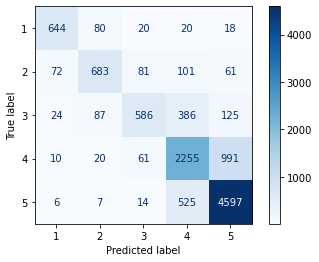

Accuracy score on test data: 0.6207737887765772
F1 macro score on test data: 0.5414255208387226
              precision    recall  f1-score   support

           1       0.68      0.67      0.67       195
           2       0.47      0.42      0.45       250
           3       0.49      0.24      0.32       302
           4       0.51      0.50      0.50       835
           5       0.71      0.82      0.76      1287

    accuracy                           0.62      2869
   macro avg       0.57      0.53      0.54      2869
weighted avg       0.61      0.62      0.61      2869



In [45]:
# Running the model on train data and validating on validation data

model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X_train1,y_train1)


# for training data
y_pred_train = model_log.predict(X_train1)

print("Accuracy score on train data:" ,accuracy_score(y_train1,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train1,y_pred_train, average='macro'))
print(classification_report(y_train1,y_pred_train))
# print(confusion_matrix(y_train1,y_pred_train))
plot_confusion_matrix(model_log, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_log.predict(X_test1)

print("Accuracy score on test data:" ,accuracy_score(y_test1,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test1,y_pred_test, average='macro'))
print(classification_report(y_test1,y_pred_test))
# print(confusion_matrix(y_test1,y_pred_test))

# plotting confusion matrix
plot_confusion_matrix(model_log, X_test1,y_test1,cmap=plt.cm.Blues); plt.show();

## Logistic regression on train data  and evaluating test data

In [46]:
tfidf_all_vector.shape # (14343, 3006)
tfidf_test_vector.shape # (6148, 3006)

(14343, 3006)

(6148, 3006)

In [47]:
### Multinomial Logistic Regression on train and evaluate test data

model_log = LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(tfidf_all_vector,y)

# for training data
y_pred_train = model_log.predict(tfidf_all_vector)

print("Accuracy score :" ,accuracy_score(y,y_pred_train))
print("F1 macro score :",f1_score(y,y_pred_train, average='macro'))
print(classification_report(y,y_pred_train))
print(confusion_matrix(y,y_pred_train))

# for test data 
test_pred = model_log.predict(tfidf_test_vector)

# Multinomial Logistic Regression on tfidf using max_featr=3000 terms, all 6 new features
# accuracy of train data is 75% and F1-macro score is 73%

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

Accuracy score : 0.7543749564247368
F1 macro score : 0.7274720463897313
              precision    recall  f1-score   support

           1       0.85      0.82      0.83       977
           2       0.75      0.67      0.71      1248
           3       0.76      0.49      0.60      1510
           4       0.68      0.66      0.67      4172
           5       0.79      0.89      0.83      6436

    accuracy                           0.75     14343
   macro avg       0.76      0.71      0.73     14343
weighted avg       0.75      0.75      0.75     14343

[[ 802  105   22   23   25]
 [ 103  841  102  129   73]
 [  23  131  738  469  149]
 [   9   40   84 2742 1297]
 [   9    9   22  699 5697]]


In [53]:
type(test_pred)
test_pred.shape
test_pred[0:5]

# converting pred values to df

df_pred = pd.DataFrame(test_pred, columns=['Rating'])
df_pred.shape

data_test.columns
df_pred["ID"] = data_test["ID"]

col_titles = ["ID","Rating"]
df_pred = df_pred.reindex(columns=col_titles)
df_pred.head()

numpy.ndarray

(6148,)

array([5, 5, 5, 4, 4], dtype=int64)

(6148, 1)

Index(['ID', 'Review', 'Clean_review', 'Length_Review', 'Length_Clean_review',
       'Polarity_rev', 'Subjectivity_rev', 'Polarity_cleanRev',
       'Subjectivity_cleanRev'],
      dtype='object')

ID  Rating
0   0       5
1   1       5
2   2       5
3   3       4
4   4       4

In [54]:
# Exporting to csv file
df_pred.to_csv(r'E:\1 P36 PROJECT\Predictions\df_pred_logreg1.csv',index=False)

## Not submitted to kaggle , just for our verification 

## Training using 3 Rating levels 

In [48]:
data['Rating_3levels'] = None
for index, rows in data.iterrows():
    if(rows['Rating'] >= 1 and rows['Rating'] < 3):
        data.at[index, 'Rating_3levels'] = '1Low'
    elif(rows['Rating'] == 3):
        data.at[index,'Rating_3levels'] = '2Medium'
    elif(rows['Rating'] > 3 and rows['Rating'] <= 5 ):
        data.at[index,'Rating_3levels'] = '3High'
data.head(3)

ID                                             Review  Rating  \
0   0  exceptional service nice all-around daughter s...       5   
1   1  beautiful relaxing jw marriott desert ridge re...       5   
2   2  great location great location 5 mins subway ta...       5   

                                        Clean_review  Length_Review  \
0  exceptional service nice around daughter staye...            937   
1  beautiful relaxing jw marriott desert ridge re...            791   
2  great location great location min subway take ...            473   

   Length_Clean_review  Polarity_rev  Subjectivity_rev  Polarity_cleanRev  \
0                  843      0.375567          0.675850           0.377948   
1                  715      0.584206          0.832460           0.584206   
2                  410      0.370370          0.535185           0.392157   

   Subjectivity_cleanRev Rating_3levels  
0               0.697279          3High  
1               0.832460          3High  
2               0.566667          3High

In [49]:
y2 = data.Rating_3levels ; y2.shape ; y2[0:5]

(14343,)

0      3High
1      3High
2      3High
3    2Medium
4      3High
Name: Rating_3levels, dtype: object

### Log reg on full train data for 3-level-rating

In [50]:
tfidf_all_vector.shape # (14343, 3006)
y2.shape

(14343, 3006)

(14343,)

In [51]:
# Running the model on full train data 
model_log= LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(tfidf_all_vector,y2)


# for training data
y_pred_train = model_log.predict(tfidf_all_vector)

print("Accuracy score on train data:" ,accuracy_score(y2,y_pred_train))
print("F1 macro score on train data:",f1_score(y2,y_pred_train, average='macro'))
print(classification_report(y2,y_pred_train))
print(confusion_matrix(y2,y_pred_train))
# plot_confusion_matrix(model_log, X_train1,y_train1,cmap=plt.cm.Blues); plt.show();

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

Accuracy score on train data: 0.9036463780241233
F1 macro score on train data: 0.7771205278239326
              precision    recall  f1-score   support

        1Low       0.87      0.87      0.87      2225
     2Medium       0.81      0.38      0.51      1510
       3High       0.92      0.99      0.95     10608

    accuracy                           0.90     14343
   macro avg       0.86      0.74      0.78     14343
weighted avg       0.90      0.90      0.89     14343

[[ 1925    64   236]
 [  219   569   722]
 [   68    73 10467]]


### SPLITTING Data using 3 rating levels

In [52]:
# # Splitting dataset in 80:20 ratio
# frpm previous models. found this ratio to give good results
X_train2,X_test2,y_train2,y_test2 = train_test_split(tfidf_all_vector,y2,test_size=0.20,random_state=123,stratify=y)
X_train2.shape # (11474, 3000)
X_train2.shape # (2869, 3000)
y.shape  # 14343 reviews

(11474, 3006)

(11474, 3006)

(14343,)

### Log reg on train data and validating on validation data for 3-level-rating 

In [53]:
# Running the model on train data and validating on validation data for 3 -level rating

model_log= LogisticRegression(random_state=123, multi_class='multinomial',solver='newton-cg')
model_log.fit(X_train2,y_train2)


# for training data
y_pred_train = model_log.predict(X_train2)

print("Accuracy score on train data:" ,accuracy_score(y_train2,y_pred_train))
print("F1 macro score on train data:",f1_score(y_train2,y_pred_train, average='macro'))
print(classification_report(y_train2,y_pred_train))
print(confusion_matrix(y_train2,y_pred_train))
# plot_confusion_matrix(model_log, X_train2,y_train2,cmap=plt.cm.Blues); plt.show();

# for test data 
y_pred_test = model_log.predict(X_test2)

print("Accuracy score on test data:" ,accuracy_score(y_test2,y_pred_test))
print("F1 macro score on test data:",f1_score(y_test2,y_pred_test, average='macro'))
print(classification_report(y_test2,y_pred_test))
print(confusion_matrix(y_test2,y_pred_test))

# plotting confusion matrix
# plot_confusion_matrix(model_log, X_test2,y_test2,cmap=plt.cm.Blues); plt.show();

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

Accuracy score on train data: 0.9056998431235838
F1 macro score on train data: 0.7821518341149213
              precision    recall  f1-score   support

        1Low       0.87      0.86      0.87      1780
     2Medium       0.84      0.38      0.53      1208
       3High       0.92      0.99      0.95      8486

    accuracy                           0.91     11474
   macro avg       0.88      0.75      0.78     11474
weighted avg       0.90      0.91      0.89     11474

[[1539   45  196]
 [ 167  462  579]
 [  55   40 8391]]
Accuracy score on test data: 0.8630184733356571
F1 macro score on test data: 0.6642520661320191
              precision    recall  f1-score   support

        1Low       0.78      0.79      0.79       445
     2Medium       0.57      0.18      0.28       302
       3High       0.89      0.98      0.93      2122

    accuracy                           0.86      2869
   macro avg       0.75      0.65      0.66      2869
weighted avg       0.84      0.86      0.84 